## CNN-SVM

CNN is very good for feature extraction but not very good for classification. SVM is the state of the art algorithm for binary classification. Combining both of them achieves best of both worlds.  

There are two ways of implementing CNN-SVM.
 - (1) The hinge loss with regularization term forms the complete SVM loss function which gives CNN_SVM implementation.
 - (2) Train the CNN model as usual and build SVM model using the output of second last layer of CNN model as an input. 

### Importing Required Libraries and Data

In [1]:
import pandas as pd
import numpy as np
#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault)
import time
import os
os.chdir("/Users/tomxu/Documents/NASA-Jet-Engine-Maintenance/Data/CMaps/")
from sklearn.preprocessing import MinMaxScaler #to normalize data
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.svm import SVC
#for deep learning
import tensorflow.keras
import tensorflow.keras.backend as k
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Activation, Masking, Dropout, Conv1D, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import History
from tensorflow.keras import callbacks

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
def prepare_data(drop_cols = True):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names
    cols_to_drop = ['OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10',
                    'SensorMeasure14', 'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']
    df_train = pd.read_csv('train_FD001.txt',delim_whitespace=True,names=input_file_column_names)
    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)
    df_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=input_file_column_names)    
    if(drop_cols == True):
        df_train = df_train.drop(cols_to_drop, axis = 1)
        df_test = df_test.drop(cols_to_drop, axis = 1)
    y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index + 1    
    return df_train, df_test, y_true

In [3]:
df_train, df_test, y_true = prepare_data(drop_cols=True)
df_train.shape, df_test.shape, y_true.shape

((20631, 18), (13096, 17), (100, 2))

In [4]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL'])

In [5]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))
df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.transform(df_test[feats])

In [6]:
df_train['failure'] = [1 if i < 50 else 0 for i in df_train.RUL]
y_true['failure'] = [1 if i < 50 else 0 for i in y_true.RUL]

In [7]:
df_train.head()

,UnitNumber,Cycle,OpSet1,OpSet2,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21,RUL,failure
0,1,1,-0.080460,-0.666667,-0.632530,-0.186396,-0.380486,0.452496,-0.515152,-0.780490,-0.261905,0.266525,-0.588235,-0.272028,-0.333333,0.426357,0.449323,191,0
1,1,2,0.218391,-0.500000,-0.433735,-0.093961,-0.294733,0.256039,-0.575758,-0.799515,-0.238095,0.530917,-0.441176,-0.177376,-0.333333,0.333333,0.462027,190,0
2,1,3,-0.494253,0.500000,-0.313253,-0.260955,-0.258947,0.420290,-0.454545,-0.719914,-0.500000,0.590618,-0.558824,-0.285110,-0.666667,0.255814,0.242751,189,0
3,1,4,0.080460,0.000000,-0.313253,-0.487683,-0.337610,0.481481,-0.363636,-0.750965,-0.666667,0.778252,-0.411765,-0.666795,-0.333333,0.147287,0.324772,188,0
4,1,5,-0.218391,-0.333333,-0.301205,-0.485066,-0.190749,0.336554,-0.515152,-0.700081,-0.488095,0.492537,-0.529412,-0.195845,-0.166667,0.178295,0.409003,187,0


In [8]:
df_test.head()

,UnitNumber,Cycle,OpSet1,OpSet2,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21
0,1,1,0.264368,0.500000,0.090361,-0.378679,-0.461175,0.304348,-0.575758,-0.744773,-0.583333,0.292111,-0.558824,-0.382070,-0.333333,0.116279,0.323667
1,1,2,-0.310345,-0.500000,-0.698795,-0.240898,-0.555368,0.610306,-0.666667,-0.706632,-0.226190,0.479744,-0.470588,-0.573682,-0.166667,0.364341,0.373654
2,1,3,0.034483,0.166667,-0.246988,-0.306736,-0.355503,0.371981,-0.545455,-0.683837,-0.226190,0.398721,-0.558824,-0.082724,-0.166667,0.457364,0.442695
3,1,4,0.482759,0.000000,-0.259036,-0.429693,-0.183997,0.359098,-0.606061,-0.788567,-0.488095,0.147122,-0.500000,-0.485956,-0.500000,0.333333,0.324220
4,1,5,0.160920,0.000000,-0.216867,-0.295836,-0.335922,0.388084,-0.666667,-0.795208,-0.452381,0.475480,-0.558824,-0.398230,-0.666667,0.317829,0.432753


In [9]:
y_true.head()

,RUL,UnitNumber,failure
0,112,1,0
1,98,2,0
2,69,3,0
3,82,4,0
4,91,5,0



LSTM expects an input in the shape of a numpy array of 3 dimensions and I will need to convert train and test data accordingly.

In [10]:
def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """        
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])    
    return np.array(lstm_array)

In [11]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [16]:
def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value    
    id_df1 = pd.concat([df_mask, id_df],ignore_index=True)    
    data_array = id_df1[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]    
    start = num_elements-seq_length
    stop = num_elements    
    lstm_array.append(data_array[start:stop, :])    
    return np.array(lstm_array)


Let's define look back period and mask_value

In [13]:
sequence_length = 50 #predicting using last 50 cycle values
mask_value = 0


Let's prepare data using above functions.

In [14]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(15731, 50, 15)


In [15]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, "failure")) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(15731,)

In [17]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 50, 15)


In [18]:
#true target of test 
y_test = y_true.RUL.values
y_test.shape

(100,)

In [19]:
nb_features = x_train.shape[2]
nb_out = 1

In [20]:
nb_features

15

In [21]:
class_0 = pd.Series(y_train).value_counts()[0]
class_1 = pd.Series(y_train).value_counts()[1]
total = class_0 + class_1
cls_wt = {0: class_1/total, 1: class_0/total}

In [22]:
cls_wt

{0: 0.3178437480134766, 1: 0.6821562519865234}

### Function to Print results

In [23]:
def print_results(y_test, y_pred):    
    #f1-score
    f1 = f1_score(y_test, y_pred)
    print("F1 Score: ", f1)
    print(classification_report(y_true.failure, y_pred))    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
    b, t = plt.ylim()
    plt.ylim(b + 0.5, t - 0.5)
    plt.title('Confuion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    #roc_auc_score
    model_roc_auc = roc_auc_score(y_test, y_pred) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(y_test, y_pred)
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    threshold = np.round(thresholds[ix],3)
    plt.subplot(222)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

### Approach 1

Converting labels in proper shape

In [24]:
def get_one_hot(targets, classes):
    res = np.eye(classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape) + [classes])

In [25]:
y_train_2 = get_one_hot(y_train, 2)
y_test_2 = get_one_hot(y_true.failure,2)

In [26]:
y_train_2

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [27]:
y_train_2.shape, y_test_2.shape

((15731, 2), (100, 2))

In [28]:
history1 = History()
model1 = Sequential()
model1.add(Conv1D(16, 3, activation = 'relu', input_shape=(sequence_length, nb_features)))
model1.add(Conv1D(16, 3, activation = 'relu'))
model1.add(MaxPooling1D(3))
model1.add(Conv1D(32, 3, activation = 'relu'))
model1.add(Conv1D(32, 3, activation = 'relu'))
model1.add(GlobalAveragePooling1D())
model1.add(Dropout(0.5))
model1.add(Dense(2, kernel_regularizer=l2(0.0001)))
model1.add(Activation('softmax'))
model1.compile(loss="hinge", optimizer="adam", metrics=['accuracy'])
model1.summary()

2022-10-04 15:40:25.441191: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-04 15:40:25.441325: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 48, 16)            736       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 46, 16)            784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 15, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 13, 32)            1568      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 11, 32)            3104      
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_____________________________________________

Fitting the model

In [29]:
%%time
# fit the model
model1.fit(x_train, y_train_2, epochs=100, batch_size=64, validation_split=0.1, verbose=1,
          callbacks = [history1, callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

2022-10-04 15:41:00.792257: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-04 15:41:00.792489: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100


2022-10-04 15:41:01.005988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


222/222 [==============================] - 7s 13ms/step - loss: 0.6975 - accuracy: 0.8217 - val_loss: 0.6209 - val_accuracy: 0.8793
Epoch 2/100
  1/222 [..............................] - ETA: 2s - loss: 0.5922 - accuracy: 0.9062

2022-10-04 15:41:07.241051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


222/222 [==============================] - 3s 12ms/step - loss: 0.6095 - accuracy: 0.8931 - val_loss: 0.6047 - val_accuracy: 0.8983
Epoch 3/100
222/222 [==============================] - 3s 12ms/step - loss: 0.5995 - accuracy: 0.9024 - val_loss: 0.6175 - val_accuracy: 0.8837
Epoch 4/100
222/222 [==============================] - 3s 12ms/step - loss: 0.5965 - accuracy: 0.9061 - val_loss: 0.6184 - val_accuracy: 0.8825
Epoch 5/100
222/222 [==============================] - 3s 12ms/step - loss: 0.5913 - accuracy: 0.9108 - val_loss: 0.6248 - val_accuracy: 0.8780
Epoch 6/100
222/222 [==============================] - 3s 12ms/step - loss: 0.5890 - accuracy: 0.9137 - val_loss: 0.6174 - val_accuracy: 0.8837
Epoch 7/100
222/222 [==============================] - 3s 12ms/step - loss: 0.5866 - accuracy: 0.9152 - val_loss: 0.6056 - val_accuracy: 0.8964
Epoch 8/100
222/222 [==============================] - 3s 12ms/step - loss: 0.5793 - accuracy: 0.9234 - val_loss: 0.6324 - val_accuracy: 0.8672
Epoc

Text(0.5, 1.0, 'Loss')

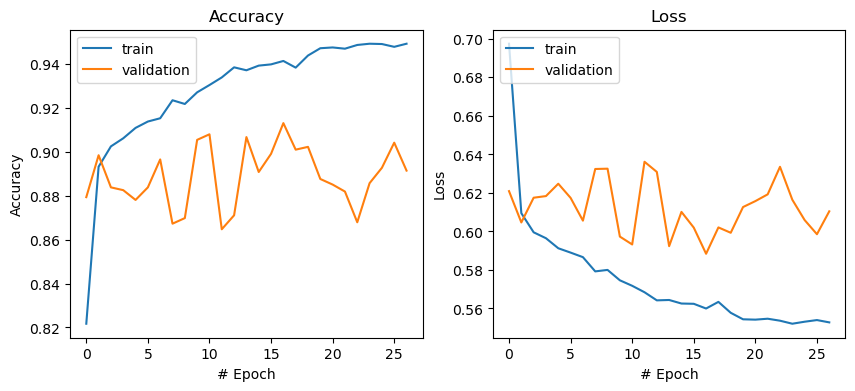

In [31]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
# Accuracy
ax[0].plot(history1.history['accuracy'])
ax[0].plot(history1.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')
# Loss
ax[1].plot(history1.history['loss'])
ax[1].plot(history1.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

2022-10-04 15:44:14.663304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


F1 Score:  0.9333333333333333
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        70
           1       0.93      0.93      0.93        30

    accuracy                           0.96       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.96      0.96      0.96       100

Area under curve :  0.9523809523809523 



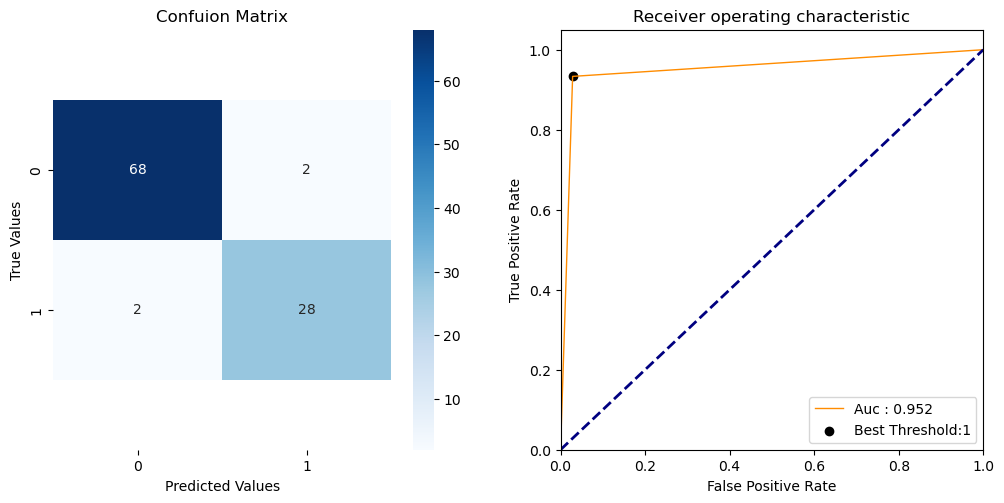

In [32]:
y_pred = np.argmax(model1.predict(x_test), axis=-1)
print_results(y_true.failure, y_pred)

In [34]:
confusion_matrix(y_train, np.argmax(model1.predict(x_train), axis=-1))

array([[10464,   267],
       [  510,  4490]])

### Approach 2

In [35]:
history2 = History()
model2 = Sequential()
model2.add(Conv1D(16, 3, activation = 'relu', input_shape=(sequence_length, nb_features)))
model2.add(Conv1D(16, 3, activation = 'relu'))
model2.add(MaxPooling1D(3))
model2.add(Conv1D(32, 3, activation = 'relu'))
model2.add(Conv1D(32, 3, activation = 'relu'))
model2.add(GlobalAveragePooling1D(name = 'feature_layer'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 48, 16)            736       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 46, 16)            784       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 16)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 13, 32)            1568      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 11, 32)            3104      
_________________________________________________________________
feature_layer (GlobalAverage (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)               

In [36]:
%%time
# fit the model
model2.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1,
          callbacks = [history2, callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Epoch 1/100


2022-10-04 15:46:25.960342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


222/222 [==============================] - 4s 12ms/step - loss: 0.3505 - accuracy: 0.8546 - val_loss: 0.2686 - val_accuracy: 0.8869
Epoch 2/100
  1/222 [..............................] - ETA: 2s - loss: 0.2426 - accuracy: 0.8906

2022-10-04 15:46:29.427917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


222/222 [==============================] - 2s 11ms/step - loss: 0.2479 - accuracy: 0.9065 - val_loss: 0.2420 - val_accuracy: 0.8907
Epoch 3/100
222/222 [==============================] - 2s 11ms/step - loss: 0.2003 - accuracy: 0.9255 - val_loss: 0.1777 - val_accuracy: 0.9149
Epoch 4/100
222/222 [==============================] - 2s 11ms/step - loss: 0.1585 - accuracy: 0.9436 - val_loss: 0.1792 - val_accuracy: 0.9219
Epoch 5/100
222/222 [==============================] - 2s 11ms/step - loss: 0.1224 - accuracy: 0.9547 - val_loss: 0.1558 - val_accuracy: 0.9269
Epoch 6/100
222/222 [==============================] - 2s 11ms/step - loss: 0.1010 - accuracy: 0.9619 - val_loss: 0.1605 - val_accuracy: 0.9257
Epoch 7/100
222/222 [==============================] - 2s 11ms/step - loss: 0.0856 - accuracy: 0.9684 - val_loss: 0.1737 - val_accuracy: 0.9301
Epoch 8/100
222/222 [==============================] - 2s 11ms/step - loss: 0.0813 - accuracy: 0.9676 - val_loss: 0.1445 - val_accuracy: 0.9365
Epoc

In [37]:
layer_name = 'feature_layer'
intermediate_layer_model = Model(inputs = model2.input,
                                outputs = model2.get_layer(layer_name).output)
cnn_x_train = intermediate_layer_model.predict(x_train)
cnn_x_test = intermediate_layer_model.predict(x_test)

2022-10-04 15:47:26.963207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [38]:
svc = SVC(kernel='rbf', C=1, gamma='auto', class_weight='balanced')
svc.fit(cnn_x_train, y_train)

SVC(C=1, class_weight='balanced', gamma='auto')

In [39]:
svc.support_vectors_.shape

(740, 32)

In [40]:
svc.score(cnn_x_train, y_train)

0.9832814188544912

F1 Score:  0.9180327868852459
              precision    recall  f1-score   support

           0       0.97      0.96      0.96        70
           1       0.90      0.93      0.92        30

    accuracy                           0.95       100
   macro avg       0.94      0.95      0.94       100
weighted avg       0.95      0.95      0.95       100

Area under curve :  0.9452380952380953 



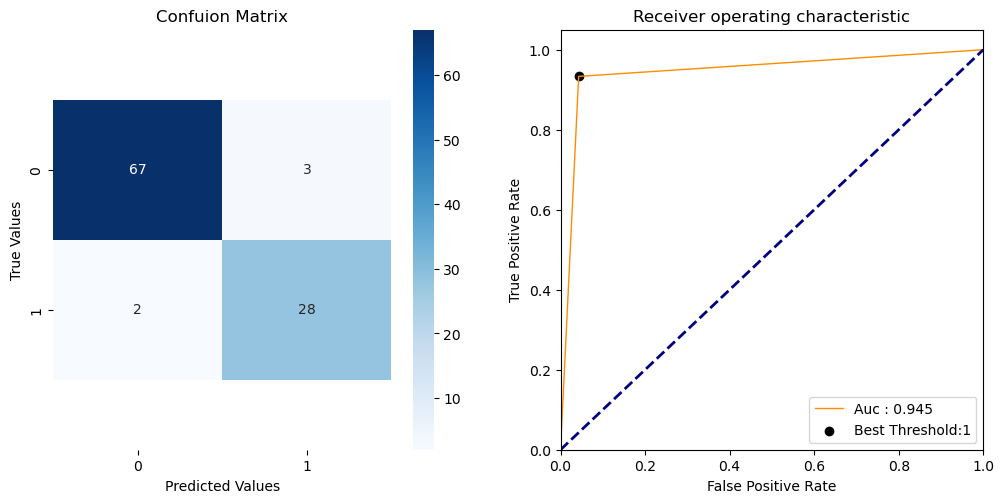

In [41]:
y_pred2 = svc.predict(cnn_x_test)
print_results(y_true.failure, y_pred2)

In [42]:
confusion_matrix(y_train, svc.predict(cnn_x_train))

array([[10533,   198],
       [   65,  4935]])